# Human Activity Recognition using TSFEL

On this example we will perform Human Activty Recognition using our library **Time Series Features Library**. 

The first step consists on importing the library. Press play. 

The import can take a few seconds, but the play button will change so that you know the import has started. Please, try to import just once.

In [0]:
#@title Import Time Series Features Library
!git clone https://github.com/TSFDlib/TSFEL.git >/dev/null 2>&1
!pip install --upgrade -q gspread >/dev/null 2>&1
!pip install gspread oauth2client >/dev/null 2>&1
!pip install pandas >/dev/null 2>&1
!pip install scipy >/dev/null 2>&1
!pip install novainstrumentation >/dev/null 2>&1
!pip install pandas_profiling >/dev/null 2>&1
!pip install --upgrade matplotlib

To check if everything was correctly imported, access "Files" (on the left side of the screen) and press "Refresh". If a TSFEL paste does not appear import again.

---


#Dataset

The dataset we will be using is open-source. It is provided by UCI and it was performed by 30 volunteers using a smartphone on the waist. It contains 6 activities: 

*   Walking
*   Standing
*   Sitting
*   Laying
*   Upstairs
*   Downstairs

To access this dataset click [here](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/) and dowload the zip "UCI_HAR_Dataset". Now, unzip the folder and upload to "Files" the following txt:

*   UCI HAR Dataset/train/Inertial Signals/total_acc_x_train.txt
*   UCI HAR Dataset/train/Inertial Signals/total_acc_y_train.txt
*   UCI HAR Dataset/train/Inertial Signals/total_acc_z_train.txt
*   UCI HAR Dataset/test/Inertial Signals/total_acc_x_test.txt
*   UCI HAR Dataset/test/Inertial Signals/total_acc_y_test.txt
*   UCI HAR Dataset/test/Inertial Signals/total_acc_z_test.txt
*   UCI HAR Dataset/train/y_train.txt
*   UCI HAR Dataset/test/y_test.txt
*   UCI HAR Dataset/activity_labels.txt






In [0]:
#@title Data Preparation
# Import libraries
import pandas as pd 
import numpy as np
import TSFEL as tslib
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
sns.set()

# Load data
x_train_sig = np.loadtxt('total_acc_x_train.txt', dtype='float32')
x_test_sig = np.loadtxt('total_acc_x_test.txt', dtype='float32')
y_test = np.loadtxt('y_test.txt', dtype='float32')
y_train = np.loadtxt('y_train.txt', dtype='float32')
activity_labels = np.array(pd.read_csv('activity_labels.txt', header=None, delimiter=' '))[:,1]

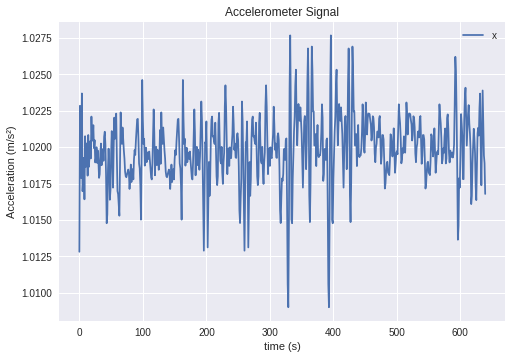

In [0]:
#@Signal Preview
plt.figure()
plt.plot(np.concatenate(x_train_sig[0:5]))
plt.xlabel("time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.title("Accelerometer Signal")
plt.legend('x axis')
plt.show()

#Feature Extraction

The features to extract are defined in the [google sheet](https://docs.google.com/spreadsheets/d/15Db3m7if7xkZBqHDUXtFxrwIcBqKvIBU0XnV6aKa4SI/edit?ts=5bd1eca0#gid=0).

Through **Feature Extraction** methodologies, the data is translated into a feature vecture containing information about the signal properties of each window. These properties can be classifier according to their domain as Time, Frequency and Statistical features and allow to characterise the signal in a compact way, enhancing its chracteristics. This features will be used as input to the machine learning classifier, thus, the chosen set of features can strongly influence the classification output.

A feature report is saved in /utils.

In [0]:
#@title Feature Extraction

# Extract excel info
cfg_file = tslib.extract_sheet()

# Get features
X_train = tslib.extract_features(x_train_sig, cfg_file, segment=False)
X_test = tslib.extract_features(x_test_sig, cfg_file, segment=False)

# Feature Selection

After the sensor data is extracted, redundancies and noise should be removed. Thus, minimising the algorithm's error, time and computational complexity. 

In [0]:
# Concatenation of entire data
features = pd.concat([X_train,X_test])
# Highly correlated features are removed
features = tslib.correlation_report(features)
X_train = features[:len(X_train)]
X_test = features[len(X_train):]

Do you wish to remove correlated features? Enter y/n: y
Removing x_Mean
Removing x_Mean absolute diff
Removing x_Median
Removing x_Median absolute deviation
Removing x_Minimum peaks
Removing x_Root mean square
Removing x_Spectral centroid
Removing x_Spectral roll-off
Removing x_Spectral skewness
Removing x_Spectral slope
Removing x_Standard Deviation
Removing x_Sum absolute diff
Removing x_Total energy
Removing x_Variance


In [0]:
#@title Preview Features
df

#Classification

In this example the classification is performed with a [Decision Tree](https://scikit-learn.org/stable/modules/tree.html) classifier.
  

In [0]:
classifier = DecisionTreeClassifier()

# Train the classifier
classifier.fit(X_train, y_train.ravel())

# Predict test data
y_test_predict = classifier.predict(X_test)

# Get the classification report
accuracy = accuracy_score(y_test, y_test_predict)
print(classification_report(y_test, y_test_predict))
print("Accuracy: " + str(accuracy) + '%')

              precision    recall  f1-score   support

         1.0       0.69      0.81      0.74       496
         2.0       0.70      0.66      0.68       471
         3.0       0.85      0.72      0.78       420
         4.0       0.58      0.55      0.57       491
         5.0       0.61      0.63      0.62       532
         6.0       1.00      1.00      1.00       537

   micro avg       0.73      0.73      0.73      2947
   macro avg       0.74      0.73      0.73      2947
weighted avg       0.74      0.73      0.73      2947

Accuracy: 0.7336274177129284%


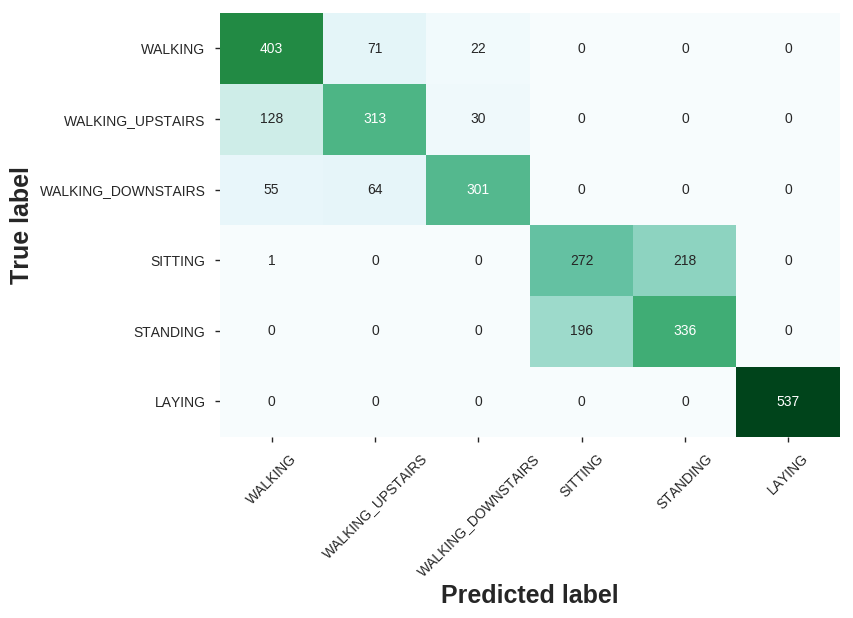

In [0]:
cm = confusion_matrix(y_test, y_test_predict)
df_cm = pd.DataFrame(cm, index=[i for i in labels], columns=[i for i in activity_labels])
plt.figure()
ax = sns.heatmap(df_cm,  cbar = False, cmap="BuGn", annot=True, fmt="d")
plt.setp(ax.get_xticklabels(), rotation=45)
plt.ylabel('True label', fontweight='bold', fontsize = 18)
plt.xlabel('Predicted label', fontweight='bold', fontsize = 18)
plt.show()

# Conclusion

As it can be seen in the confusion matrix, the misclassification was higher between WALKING UPSTAIRS vs WALKING DOWNSTAIRS vs WALKING and SITTING vs STANDING. Dynamic activities, due to their distinct motion characteristics and cyclic behaviour, were clearly discriminated against static activities.

In [0]:
#@title Improvements
# Load data
y_train_sig = np.loadtxt('total_acc_y_train.txt', dtype='float32')
y_test_sig = np.loadtxt('total_acc_y_test.txt', dtype='float32')
z_train_sig = np.loadtxt('total_acc_z_train.txt', dtype='float32')
z_test_sig = np.loadtxt('total_acc_z_test.txt', dtype='float32')
import numba      
#get accelerometer train and test data magnitude
# Extract excel info
cfg_file = tslib.extract_sheet()

@numba.jit
def magnitude(all_sig):
  mag_train = []
  for i in range(len(all_sig[0])):
    mag_row= []
    for j in range(len(all_sig[0][i])):
        mag_row.append(np.sqrt(all_sig[0][i,j]**2 + all_sig[1][i,j]**2 + all_sig[2][i,j]**2))
    mag_train.append(mag_row)
  
  return np.array(mag_train)

## Data Preparation
@numba.jit
def extract_sig(dir, sig_name, mag=True):
  feat = pd.DataFrame()
  all_sig = []
  for idx_d, d in enumerate(dir):
    sig = np.loadtxt(d, dtype='float32')
    XMag_test = tslib.extract_features(sig, sig_name[idx_d], cfg_file, segment=False)
    feat = pd.concat([feat, XMag_test], axis=1)
    if mag:
      all_sig.append(sig)
      if idx_d == 2 or idx_d == 5 or idx_d == 8:
        _mag = magnitude(all_sig)
        feat_mag = tslib.extract_features(_mag, sig_name[idx_d+1], cfg_file, segment=False)
        feat = pd.concat([feat, feat_mag], axis=1)
        all_sig=[]
  return feat


dir = ['total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt', 
       'body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt',
      'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt']
sig_name = ['tot_x', 'tot_y', 'tot_z','tot_mag', 'body_x', 'body_y', 'body_z', 'body_mag',
           'gyr_x', 'gyr_y', 'gyr_z', 'gyr_mag']
print("*** Feature extraction started ***")
X_train = extract_sig(dir, sig_name, mag=True)

dir = ['total_acc_x_test.txt', 'total_acc_y_test.txt', 'total_acc_z_test.txt', 
       'body_acc_x_test.txt', 'body_acc_y_test.txt', 'body_acc_z_test.txt',
      'body_gyro_x_test.txt', 'body_gyro_y_test.txt', 'body_gyro_z_test.txt']
X_test = extract_sig(dir, sig_name, mag=True)
print("*** Feature extraction finished ***")

## Feature Selection
# Concatenation of entire data
names = [Xt.replace(" ", "_") for Xt in X_train.columns]
features = pd.concat([X_train,X_test], names=names)
# Highly correlated features are removed
#features = tslib.correlation_report(features)
X_train = features[:len(X_train)]
X_test = features[len(X_train):]

# Classification
classifier = DecisionTreeClassifier()
# Train the classifier
classifier.fit(X_train, y_train.ravel())
# Predict test data
y_test_predict = classifier.predict(X_test)

# Get the classification report
accuracy = accuracy_score(y_test, y_test_predict)
print(classification_report(y_test, y_test_predict))
print("Accuracy: " + str(accuracy) + '%')

*** Feature extraction started ***


In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

classifier = GaussianNB()

features = pd.concat([X_train,X_test], names=names)

def FSE(X_train, X_test, y_train, y_test, labs, classifier):
    total_acc, FS_lab, acc_list = [], [], []
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    for feat_idx, feat_name in enumerate(labs):
        classifier.fit(X_train[:,feat_idx].reshape(-1,1), y_train)
        y_test_predict = classifier.predict(X_test[:,feat_idx].reshape(-1,1))
        acc_list.append(accuracy_score(y_test, y_test_predict))

    curr_acc_idx = np.argmax(acc_list)
    FS_lab.append(labs[curr_acc_idx])
    last_acc = acc_list[curr_acc_idx]
    FS_X_train = X_train[:,curr_acc_idx]
    FS_X_test = X_test[:,curr_acc_idx]
    total_acc.append(last_acc)

    counter = 1
    while 1:
        acc_list = []
        for feat_idx, feat_name in enumerate(labs):
            if feat_name not in FS_lab:
                curr_train = np.column_stack((FS_X_train, X_train[:, feat_idx]))
                curr_test = np.column_stack((FS_X_test, X_test[:, feat_idx]))
                classifier.fit(curr_train, y_train)
                y_test_predict = classifier.predict(curr_test)
                acc_list.append(accuracy_score(y_test, y_test_predict))
            else:
                acc_list.append(0)
        curr_acc_idx = np.argmax(acc_list)
        if last_acc < acc_list[curr_acc_idx]:
            FS_lab.append(labs[curr_acc_idx])
            last_acc = acc_list[curr_acc_idx]
            total_acc.append(last_acc)

            FS_X_train = np.column_stack((FS_X_train, X_train[:, curr_acc_idx]))
            FS_X_test = np.column_stack((FS_X_test, X_test[:, curr_acc_idx]))
        else:
            print("FINAL Features: " + str(FS_lab))
            print("Number of features", len(FS_lab))
            print("Acc: ", str(total_acc))
            print("From ", str(len(X_train[0])), "to ", str(len(FS_lab)))

            break
        counter += 1
        print(counter)
    return np.array(FS_X_train), np.array(FS_X_test), np.array(FS_lab)

# Classifiers
names = ["Naive Bayes"]
classifiers = [
    GaussianNB()
]

best = 0
best_classifier = None
best_y_test_pred = None
best_clf = None

labels=np.concatenate((y_train, y_test))
for n, c in zip(names, classifiers):
    print(n)
    
    FS_X_train, FS_X_test, FS_lab_description = FSE(X_train, X_test, y_train, y_test, list(X_train.columns), c)
    
    # Train the classifier
    c.fit(X_train, y_train.ravel())

    # Predict test data
    y_test_predict = c.predict(X_test)

    # Get the classification accuracy
    accuracy = accuracy_score(y_test, y_test_predict)
    scores = cross_val_score(c, features, labels, cv=10)
    print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
    
    print("Accuracy: " + str(accuracy) + '%')
    print('-----------------------------------------')
    if np.mean([scores.mean(), accuracy]) > best:
        best_classifier = n
        best_y_test_pred = y_test_predict
        best = np.mean([scores.mean(), accuracy])
        best_clf = c

print('******** Best Classifier: ' + str(best_classifier) + ' ********')

In [59]:
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
def find_best_classifier(features, subj_lab, X_train, X_test, y_train, y_test):
    """
    This function performs the classification of the given features using several classifiers. From the obtained results
    the classifier which best fits the data and gives the best result is chosen and the respective confusion matrix is
    showed.
    :param  features: (array)
            features
    :param  labels: (array)
            features respective labels
    :param  classes: (str list)
            names of the existing classes
    """
    # Split into train and test sets
    # X_train, X_test, y_train, y_test = train_test_split(test_features, test_labels, test_size=0.3, random_state=42)

    # Classifiers
    print("USING GRID SEARCH")
    acc = []
    names = ["Nearest Neighbors", "Decision Tree", "Random Forest", "SVM", "AdaBoost", "Naive Bayes", "QDA"]
    classifiers = [
        DecisionTreeClassifier(max_depth=5, min_samples_split=len(features)//10),
        RandomForestClassifier(max_depth=5, n_estimators=10, max_features=2),
        svm.SVC(),
        AdaBoostClassifier(),
        GaussianNB(),
        QuadraticDiscriminantAnalysis()
        ]

    best = 0
    best_classifier = None
    best_clf = None
    # train_size = len_annotated_set/len(labels)
    # Split into train and test sets
    for n, c in zip(names, classifiers):
        counter = 0
        n_iter_search = 20
        print(n)

        if n == "Random Forest":
            # specify parameters and distributions to sample from
            param_dist = {"max_depth": [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17, None],
                              "max_features": sp_randint(1, 20),
                              "min_samples_split": sp_randint(2, 18),
                              "min_samples_leaf": sp_randint(1, 18),
                              "bootstrap": [True, False],
                              "criterion": ["gini", "entropy"],
                              "n_estimators": sp_randint(5, 20)}
            # run randomized search
            grid = RandomizedSearchCV(c, param_dist, cv=10, scoring='accuracy', n_iter=n_iter_search)
            grid.fit(X_train, y_train)
            grid = grid.best_estimator_

        elif n == 'SVM':
            Cs = [0.001, 0.01, 0.1, 1, 10]
            gammas = [0.001, 0.01, 0.1, 1]
            C_range = 10. ** np.arange(-3, 8)
            gamma_range = 10. ** np.arange(-5, 4)
            param_dist = {'shrinking': [True, False], 'decision_function_shape':['ovo','ovr'],'C': C_range, 'gamma': gamma_range}
            # run randomized search
            grid = GridSearchCV(c, param_dist, cv=10, scoring='accuracy')
            grid.fit(X_train, y_train)
            grid = grid.best_estimator_
        elif n == 'Decision Tree':
            param_dist = { "criterion": ["gini", "entropy"],
                           'splitter': ['best','random'],
                           "min_samples_split": sp_randint(2, 11),
                           "min_samples_leaf": sp_randint(1, 11),
                           "max_depth": sp_randint(1, 11)
                           }
            # run randomized search
            grid = RandomizedSearchCV(c, param_dist, cv=2, scoring='accuracy', n_iter=n_iter_search)
            grid.fit(X_train, y_train)
            grid = grid.best_estimator_
        else:
            # Train the classifier
            grid = c
            grid.fit(X_train, y_train)

        # print grid.get_params()
        scores = cross_val_score(grid, features, subj_lab, cv=5)

        print("Accuracy: " + str(np.mean(scores)) + '%')
        print(np.std(scores))
        print('-----------------------------------------')
        if np.mean(scores) > best:
            best_classifier = n
            best = np.mean(scores)
            best_clf = grid

    print('******** Best Classifier: ' + str(best_classifier) + ' ********')
    
    print(best_clf)
    return best_clf, best
  
clas, best = find_best_classifier(np.concatenate([FS_X_train, FS_X_test]), np.concatenate([y_train, y_test]), FS_X_train, FS_X_test, y_train, y_test)

USING GRID SEARCH
GaussianNB
Accuracy: 0.839128210564726%
0.03527104417486182
-----------------------------------------
******** Best Classifier: GaussianNB ********
GaussianNB(priors=None, var_smoothing=1e-09)
